# 네이버 뉴스기사 크롤링 분류 프로젝트

목적: 네이버 뉴스 기사를 크롤링해서 카테고리 분류

- 카테고리 번호
    - 100: 정치
    - 101: 경제
    - 102: 사회
    - 103: 생활/문화
    - 104: 세계
    - 105: IT/과학


평기기준:
1. 한국어 전치 과정이 적젏하였는가?
    - 형태소 분석기 선택과 불용어 제거가 체계적으로 진행됨
2. 텍스트 데이터 수집이 분량과 다양성 측면에서 저절했는가?
    - 일자와 분량에서 텍스트 데이터 다양성 향상을 위한 노력이 확인됨
3. 분류모델의 test accuracy가 기준 이상 높게 나왔는가?
    - f-1 score 기준 83% 이상의 정확도가 확인됨


## 크롤러 만들기

### BeautifulSoup

In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
from newspaper import Article

#### make_urllist

URL 리스트를 리턴하는 함수 </br>
원하는 페이지수, 카테고리 번호, 날짜를 입력값으로 받는다.

In [2]:
def make_urllist(page_num, code, date): 
  urllist= []
  for i in range(1, page_num + 1):
    url = 'https://news.naver.com/main/list.nhn?mode=LSD&mid=sec&sid1='+str(code)+'&date='+str(date)+'&page='+str(i)
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36'}
    # lang="ko" data-useragent="Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
    news = requests.get(url, headers=headers)

    # BeautifulSoup의 인스턴스 생성(파서는 html.parser를 사용)
    soup = BeautifulSoup(news.content, 'html.parser')

    # CASE 1
    news_list = soup.select('.newsflash_body .type06_headline li dl')
    
    # CASE 2
    news_list.extend(soup.select('.newsflash_body .type06 li dl'))
        
    # 각 뉴스로부터 a 태그인 <a href ='주소'> 에서 '주소'만 가져옴
    for line in news_list:
        urllist.append(line.a.get('href'))
  return urllist

In [3]:
url_list = make_urllist(2, 105, 20231128)
print(f'뉴스 기사 개수 = {len(url_list)}')

뉴스 기사 개수 = 40


In [4]:
url_list[:5]

['https://n.news.naver.com/mnews/article/009/0005222155?sid=105',
 'https://n.news.naver.com/mnews/article/020/0003533945?sid=105',
 'https://n.news.naver.com/mnews/article/092/0002313077?sid=105',
 'https://n.news.naver.com/mnews/article/008/0004967473?sid=105',
 'https://n.news.naver.com/mnews/article/056/0011611479?sid=105']

### newspaper3k

#### make_data

URL 리스트와 해당 URL이 어떤 카테고리인지 코드를 알려주면 이를 통해 데이터프레임 생성하는 함수 </br>
URL_list와, 카테고리를 입력 받는다.

In [5]:
idx2word = {'100' : '정치', '101' : '경제', '102' : '사회', '103' : '생활/문화', '104' : '세계','105' : 'IT/과학'}

def make_data(urllist, code):
    text_list = []
    for url in urllist:
        article = Article(url, language='ko')
        article.download()
        article.parse()
        text_list.append(article.title)

    #- 데이터프레임의 'news' 키 아래 파싱한 텍스트를 밸류로 붙여줌
    df = pd.DataFrame({'news': text_list})

    #- 데이터프레임의 'code' 키 아래 한글 카테고리명을 붙여줌
    df['code'] = idx2word[str(code)]
    return df

In [6]:
# 상위 10개 추출

data = make_data(url_list, 105)
data[:10]

,news,code
0,우리 할머니 인슐린 주사 그만 맞아도 될까…‘당뇨 완치’ 길 열리나,IT/과학
1,"강스템바이오텍, ‘퓨어스템 오에이 키트주’ 임상 순항… “기술수출에 최선”",IT/과학
2,"DN솔루션즈, 獨 테크니컬 센터 열어…""유럽 시장 잡는다""",IT/과학
3,대구경북과학기술원 신임 총장에 이건우 서울대 전 공대 학장,IT/과학
4,울산 남구 테크노산업로 일원 자율주행차 시범운행지구 지정,IT/과학
5,"유니스트, ‘세계에서 가장 영향력 있는 연구자’ 9명",IT/과학
6,"이용훈 총장, 과기부 장관 ‘물망’…유니스트는?",IT/과학
7,"쿠쿠전자, 대용량 '아이편한 가습기 7S' 출시",IT/과학
8,욕설 논란에 카르텔 폭로까지…스텝 꼬인 김범수 쇄신안,IT/과학
9,“이런 XXX같은” 욕설 회의... 카카오 임원 “문제점 지적하다 실수”,IT/과학


## 데이터 수집 및 전처리

### 데이터 수집

In [7]:
# 다른 카테고리의 뉴스들도 수집
code_list = [100, 101, 102, 103, 104, 105]
code_list

[100, 101, 102, 103, 104, 105]

#### make_total_data

특정 날짜의 여러 카테고리의 뉴스를 수집하는 함수 </br>
코드리스트, 페이수, 날짜를 입력 받는다.

In [8]:
def make_total_data(page_num, code_list, date):
    df = None
    
    for code in code_list:
        url_list = make_urllist(page_num=page_num, code=code, date=date)
        df_temp = make_data(url_list, code)
        print(str(code)+'번 코드에 대한 데이터 생성')

        if df is not None:
            df = pd.concat([df, df_temp])
        else:
            df = df_temp

    return df
            

In [9]:
df = make_total_data(1, code_list, 20231128)

100번 코드에 대한 데이터를 만들었습니다.
101번 코드에 대한 데이터를 만들었습니다.
102번 코드에 대한 데이터를 만들었습니다.
103번 코드에 대한 데이터를 만들었습니다.
104번 코드에 대한 데이터를 만들었습니다.
105번 코드에 대한 데이터를 만들었습니다.


In [10]:
print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  120


In [11]:
df.sample(10)

,news,code
13,카이스트 인공지능반도체대학원 개원,IT/과학
10,PAKISTAN PROTEST,세계
3,"“프란치스코 교황, 기후변화협약 당사국총회 예정대로 참석”",세계
19,미국 주택가격 8개월 연속 상승…9월 전월대비 0.3%↑,경제
15,“전쟁 폐허 극복한 부산의 저력 공유”… ‘연대의 엑스포’ 역설 [엑스포 개최지 선정],사회
15,USA WHITE HOUSE BIDEN CARTER,세계
15,"부산디지털자산거래소 사업자, 블록체인 ‘큰손’ 2파전",IT/과학
9,"동아제약, 중대재해 대응 모의훈련 실시…심폐소생술 등 교육",생활/문화
8,[속보]2030 엑스포 후보 3개국 최종 PT 종료…투표 시작,정치
16,엑스포 최종 PT 30분전 총회장 로비서 한·사우디 신경전(종합),경제


#### 대량 크롤링

In [69]:
date_list = [20231125, 20231126, 20231127, 20231128, 20231129, 20231130, 20231201]
merged_df = pd.DataFrame()

for idx, date in enumerate(date_list):
    df = make_total_data(2, code_list, date)
    merged_df = pd.concat([merged_df, df])

csv_path = os.path.join(os.getenv("HOME"), "aiffel/news_crawler/merged_data.csv")
merged_df.to_csv(csv_path, index=False)

if os.path.exists(csv_path):
    print('{} File Saved!'.format(csv_path))

100번 코드에 대한 데이터를 만들었습니다.
101번 코드에 대한 데이터를 만들었습니다.
102번 코드에 대한 데이터를 만들었습니다.
103번 코드에 대한 데이터를 만들었습니다.
104번 코드에 대한 데이터를 만들었습니다.
105번 코드에 대한 데이터를 만들었습니다.
100번 코드에 대한 데이터를 만들었습니다.
101번 코드에 대한 데이터를 만들었습니다.
102번 코드에 대한 데이터를 만들었습니다.
103번 코드에 대한 데이터를 만들었습니다.
104번 코드에 대한 데이터를 만들었습니다.
105번 코드에 대한 데이터를 만들었습니다.
100번 코드에 대한 데이터를 만들었습니다.
101번 코드에 대한 데이터를 만들었습니다.
102번 코드에 대한 데이터를 만들었습니다.
103번 코드에 대한 데이터를 만들었습니다.
104번 코드에 대한 데이터를 만들었습니다.
105번 코드에 대한 데이터를 만들었습니다.
100번 코드에 대한 데이터를 만들었습니다.
101번 코드에 대한 데이터를 만들었습니다.
102번 코드에 대한 데이터를 만들었습니다.
103번 코드에 대한 데이터를 만들었습니다.
104번 코드에 대한 데이터를 만들었습니다.
105번 코드에 대한 데이터를 만들었습니다.
100번 코드에 대한 데이터를 만들었습니다.
101번 코드에 대한 데이터를 만들었습니다.
102번 코드에 대한 데이터를 만들었습니다.
103번 코드에 대한 데이터를 만들었습니다.
104번 코드에 대한 데이터를 만들었습니다.
105번 코드에 대한 데이터를 만들었습니다.
100번 코드에 대한 데이터를 만들었습니다.
101번 코드에 대한 데이터를 만들었습니다.
102번 코드에 대한 데이터를 만들었습니다.
103번 코드에 대한 데이터를 만들었습니다.
104번 코드에 대한 데이터를 만들었습니다.
105번 코드에 대한 데이터를 만들었습니다.
100번 코드에 대한 데이터를 만들었습니다.
101번 코드에 대한 데이터를 만들었습니다.
102번 코드에 대한 데이터를 만들었습니다.
103번 코드에 대한 데이터를 만들었습니다.


In [14]:
df = make_total_data(10, code_list, 20231128)

100번 코드에 대한 데이터를 만들었습니다.
101번 코드에 대한 데이터를 만들었습니다.
102번 코드에 대한 데이터를 만들었습니다.
103번 코드에 대한 데이터를 만들었습니다.
104번 코드에 대한 데이터를 만들었습니다.
105번 코드에 대한 데이터를 만들었습니다.


#### csv file로 저장

In [70]:
import os

csv_path = os.getenv("HOME") + "/aiffel/news_crawler/merged_data.csv"
df.to_csv(csv_path, index=False)

if os.path.exists(csv_path):
  print('{} File Saved!'.format(csv_path))

/aiffel/aiffel/news_crawler/merged_data.csv File Saved!


### 데이터 전처리

#### 데이터 정제

In [150]:
csv_path = os.getenv("HOME") + "/aiffel/news_crawler/news_data_001.csv"
df = pd.read_table(csv_path, sep=',')
df.head()

,news,code
0,[속보] 2030 엑스포 후보 3개국 최종 PT 종료…투표 절차 시작,정치
1,[BIE총회][속보] 투표 절차 시작,정치
2,[속보] 2030 엑스포 후보 3개국 최종 PT 종료…투표 절차 시작,정치
3,[속보] 2030 엑스포 후보 3개국 최종 PT 종료…투표 절차 시작,정치
4,"“민관 유치 총결집, 韓 외교역량 한 단계 발전” [엑스포 개최지 선정]",정치


In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   news    5995 non-null   object
 1   code    6000 non-null   object
dtypes: object(2)
memory usage: 93.9+ KB


In [152]:
# 정규 표현식을 이용해서 한글 외의 문자는 전부 제거
df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df['news']

/tmp/ipykernel_34/950953648.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


0             속보  엑스포 후보 개국 최종  종료투표 절차 시작
1                            총회속보 투표 절차 시작
2             속보  엑스포 후보 개국 최종  종료투표 절차 시작
3             속보  엑스포 후보 개국 최종  종료투표 절차 시작
4       민관 유치 총결집  외교역량 한 단계 발전 엑스포 개최지 선정
                       ...                
5995                      하나증권 토큰증권 시스템 지원
5996                 만원인데 이 정도면 충분 갤럭시 점프 
5997                    재난재해 현장 구호복구돕는  지프
5998          카카오페이신한은행 쓸수록 모이는 소비적금 내달 출시
5999              삼성 자회사 하만 음악 재생 플랫폼 룬 인수
Name: news, Length: 6000, dtype: object

In [153]:
# null 값 확인
print(df.isnull().sum())

news    5
code    0
dtype: int64


In [154]:
df.dropna(inplace=True)

In [155]:
print(df.isnull().sum())

news    0
code    0
dtype: int64


In [156]:
# 중복 값 제거
df.drop_duplicates(subset=['news'], inplace=True)

print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  4570


#### 데이터 탐색

<AxesSubplot:>

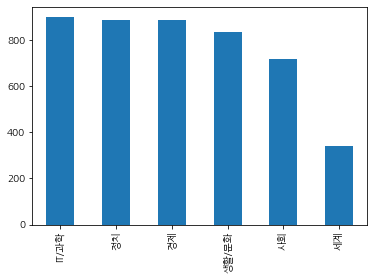

In [157]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "NanumGothic"

df['code'].value_counts().plot(kind = 'bar')

In [158]:
print(df.groupby('code').size().reset_index(name = 'count'))

    code  count
0  IT/과학    899
1     경제    886
2     사회    718
3  생활/문화    835
4     세계    343
5     정치    889


#### 토큰화 / 불용어 제거

In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4570 entries, 0 to 5998
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   news    4570 non-null   object
 1   code    4570 non-null   object
dtypes: object(2)
memory usage: 107.1+ KB


In [160]:
stopwords = ['에','는','은','을','했','에게','있','이','의','하','한','다','과',
             '때문','할','수','무단','따른','및','금지','전재','경향신문','기자','는데',
             '가','등','들','파이낸셜','저작','등','뉴스','기사', '뉴스', '말했다', '전', 
             '대해', '위해', '대한', '이를', '또한', '지난', '말했', '오늘', '그리고', '오전', 
             '오후', '밝혔다', '한다', '에서', '으로', '관련', '현재', '경우', '이후', '이에', '알려졌다', 
             '다른', '때문에', '물론', '한편']

##### Mecab

In [161]:
from konlpy.tag import Mecab
tokenizer = Mecab()

# 토큰화 및 토큰화 과정에서 불용어를 제거하는 함수
def preprocessing(data):
  text_data = []

  for sentence in data:
    temp_data = []
    #- 토큰화
    temp_data = tokenizer.morphs(sentence) 
    #- 불용어 제거
    temp_data = [word for word in temp_data if not word in stopwords] 
    text_data.append(temp_data)

  text_data = list(map(' '.join, text_data))

  return text_data

In [162]:
text_data = preprocessing(df['news'])
print(text_data[0])

속보 엑스포 후보 개국 최종 종료 투표 절차 시작


##### kkma

In [110]:
# from konlpy.tag import Kkma
# from nltk.corpus import stopwords

# # 불용어 설정
# stopwords = set(stopwords.words('korean'))

# # Kkma 토크나이저 초기화
# kkma_tokenizer = Kkma()

# # 텍스트 전처리 함수
# def preprocessing_kkma(data):
#     text_data = []

#     for sentence in data:
#         temp_data = []
#         # 토큰화
#         temp_data = kkma_tokenizer.morphs(sentence)
#         # 불용어 제거
#         temp_data = [word for word in temp_data if word not in stopwords]
#         text_data.append(temp_data)

#     text_data = list(map(' '.join, text_data))

#     return text_data

OSError: No such file or directory: '/aiffel/nltk_data/corpora/stopwords/korean'

## 모델

In [163]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from 
from sklearn.metrics import classification_report

### 훈련 데이터와 테스트 데이터를 분리

In [164]:
#- 훈련 데이터와 테스트 데이터를 분리
X_train, X_test, y_train, y_test = train_test_split(text_data, 
                                                    df['code'], 
                                                    random_state = 0)

In [165]:
print('훈련용 뉴스 기사의 개수 :', len(X_train))
print('테스트용 뉴스 기사의 개수 : ', len(X_test))
print('훈련용 레이블의 개수 : ', len(y_train))
print('테스트용 레이블의 개수 : ', len(y_test))

훈련용 뉴스 기사의 개수 : 3427
테스트용 뉴스 기사의 개수 :  1143
훈련용 레이블의 개수 :  3427
테스트용 레이블의 개수 :  1143


### 모델 학습

In [200]:
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

In [201]:
#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻음
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [208]:
#- 나이브 베이즈 분류기를 수행
#- X_train은 TF-IDF 벡터, y_train은 레이블
clf = MultinomialNB(alpha=0.3, 
                    fit_prior=True).fit(X_train_tfidf, y_train)

In [209]:
# 텍스트를 입력하면 자동으로 TF-IDF 벡터로 바꾸는 전처리 함수
def tfidf_vectorizer(data):
  data_counts = count_vect.transform(data)
  data_tfidf = tfidf_transformer.transform(data_counts)
  return data_tfidf

In [210]:
# 정치, 사회
new_sent = preprocessing(["민주당 일각에서 법사위의 체계·자구 심사 기능을 없애야 한다는 \
                           주장이 나오는 데 대해 “체계·자구 심사가 법안 지연의 수단으로 \
                          쓰이는 것은 바람직하지 않다”면서도 “국회를 통과하는 법안 중 위헌\
                          법률이 1년에 10건 넘게 나온다. 그런데 체계·자구 심사까지 없애면 매우 위험하다”고 반박했다."])
print(clf.predict(tfidf_vectorizer(new_sent)))

['정치']


In [211]:
# 생활/문화
new_sent = preprocessing(["인도 로맨틱 코미디 영화 <까립까립 싱글>(2017)을 봤을 때 나는 두 눈을 의심했다. \
                          저 사람이 남자 주인공이라고? 노안에 가까운 이목구비와 기름때로 뭉친 파마머리와, \
                          대충 툭툭 던지는 말투 등 전혀 로맨틱하지 않은 외모였다. 반감이 일면서 \
                          ‘난 외모지상주의자가 아니다’라고 자부했던 나에 대해 회의가 들었다.\
                           티브이를 꺼버릴까? 다른 걸 볼까? 그런데, 이상하다. 왜 이렇게 매력 있지? 개구리와\
                            같이 툭 불거진 눈망울 안에는 어떤 인도 배우에게서도 느끼지 못한 \
                            부드러움과 선량함, 무엇보다 슬픔이 있었다. 2시간 뒤 영화가 끝나고 나는 완전히 이 배우에게 빠졌다"])
print(clf.predict(tfidf_vectorizer(new_sent)))

['생활/문화']


In [212]:
# IT/과학
new_sent = preprocessing(["20분기 연속으로 적자에 시달리는 LG전자가 브랜드 이름부터 성능, 디자인까지 대대적인 변화를 \
                          적용한 LG 벨벳은 등장 전부터 온라인 커뮤니티를 뜨겁게 달궜다. 사용자들은 “디자인이 예쁘다”, \
                          “슬림하다”는 반응을 보이며 LG 벨벳에 대한 기대감을 드러냈다."])
print(clf.predict(tfidf_vectorizer(new_sent)))

['경제']


In [213]:
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       IT/과학       0.63      0.83      0.72       227
          경제       0.59      0.58      0.59       226
          사회       0.68      0.57      0.62       163
       생활/문화       0.67      0.62      0.65       212
          세계       0.95      0.46      0.62        87
          정치       0.78      0.85      0.81       228

    accuracy                           0.68      1143
   macro avg       0.72      0.65      0.67      1143
weighted avg       0.69      0.68      0.68      1143



# 회고

- 어려웠던 점
    - 크롤링하는데 시간이 엄청 오래걸렸다.
        - 3시간 중 거의 반을 기다려서 로컬이랑 클라우드에서 같이 돌려서 아무것도 못했다.
    - 다른 형태소를 쓰려고 했는데 에러가 나서 열심히 찾아봤는데 모르겠습니다.
        - kkma, okt 모두 에러뜸...
    - 

- 해결?
    - 구굴링과 팀원들과 얘기를해서 해결하려고 했습니다.
    
크롤링은 너무 어려웠던 거 같습니다..
처음 쓰는 모델이라서 잘 몰라서 헤매기도 했고, 공부를 더 열심히 해야할 거 같습니다.